<a href="https://colab.research.google.com/github/Amrapali03/Learn-PyTorch/blob/main/MNIST_Classification_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification Using PyTorch

In this notebook we're going to go through all the steps from start to finish of a typical deep learning project. We' will use the MNIST dataset which consists of handwritten digits 0-9 and use a simple neural network to classify them.

## Set up

In [ ]:
!pip install -q torchsummaryX

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummaryX import summary
import sklearn
import sklearn.metrics
from tqdm.auto import tqdm
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


## Data Loading & Processing

We can load the MNIST dataset directly from PyTorch and use it to make a dataloader. Here, we don't have a separate validation dataset so we use 20% of the train data to make up our validation dataset. It's a typical thing to split the training data into training set and validation set.

The only processing we're doing here is transforming all the data to a Pytorch tensor so we can feed it into the model. In addition to converting raw images into tensor, we might also add some augmentations for achieving better performance but you will see this in future assignments. Let's keep things simple for now.

In [ ]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST('./train', download=True, train=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8,0.2])
test_dataset = torchvision.datasets.MNIST('./test', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Now that we've loaded our data, let's see what it looks like. Understanding the dimensions of data is extremely important as well. We can see that the features are of shape `B x 1 x 28 x 28` where `B` is batch size, and `1 X 28 X 28` represents a shape of single image(MNIST images are gray, that's why images have single color channel).


Since we're using an [MLP(multi-layer perceptrons)](https://en.wikipedia.org/wiki/Feedforward_neural_network#Multilayer_perceptron), we will have to flatten the images so our data is of shape B x 784. This is because MLP expects single dimensional input.

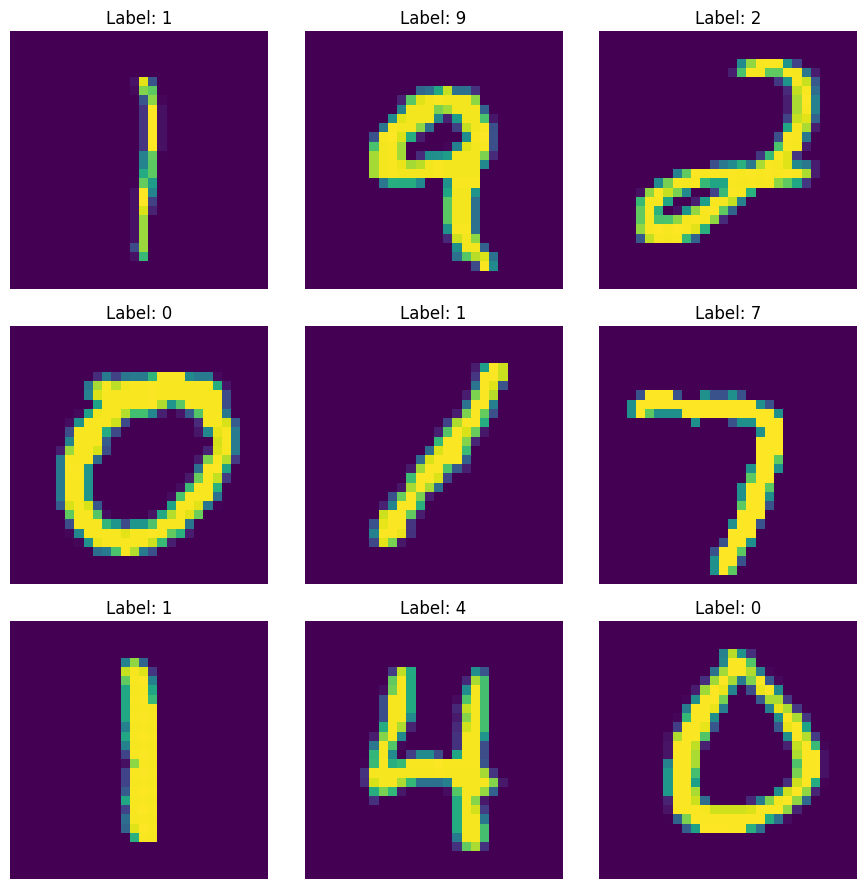

Data shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(9, 9))  # Setting the figure size to ensure images are displayed properly

# This loop goes through the batches of the train_loader.
for i, data in enumerate(train_loader):
    if i >= 9:  # Break the loop after displaying 9 images
        break
    ''' x contains the image data and y contains the labels.
    The img variable takes the first image in the batch, and label takes its corresponding label.
    The image is then converted to a NumPy array for plotting.'''
    x, y = data

    '''In this example, the batch size is 64, so x has a shape of [64, 1, 28, 28]
    x[0, :, :, :] selects the first image in the batch. The slicing : in each dimension indicates taking the entire range of that dimension
    The result is an image tensor of shape [1, 28, 28]'''
    img, label = x[0, :, :, :], y[0].item() # .item converts the tensor containing the label to a standard Python scalar
    npimg = img.numpy()

    plt.subplot(3, 3, i+1)  # Display the image in a 3x3 grid, i + 1 specifies the position of the current subplot in the grid
    plt.imshow(npimg.squeeze()) # remove single-dimensional entries from the shape of an array[28,28], which is useful for displaying grayscale images.
    plt.title(f'Label: {label}')
    plt.axis('off')  # Turn off axis numbers and ticks

# Display all images at once
plt.tight_layout()
plt.show()

print(f'Data shape: {x.shape}')
print(f'Label shape: {y.shape}')

## Training & Evaluation

Now that we have our dataloaders working pretty well, we can focus on setting up training. Referring to the slides we can see that the first thing we should do now is build the model. For the purposes of this notebook we're going to use a one hidden layer neural network with ReLU activation. There's different ways of defining models in PyTorch but for simple models like this using `torch.nn.Sequential` is the most convenient way.

Since the input to the nn.Linear layer needs to be a 1D tensor of size 28*28, the data is flattened starting from the second dimension (i.e., the height and width dimensions).

In [ ]:
IN_SIZE = 28 * 28
HIDDEN_SIZE = 1024
OUT_SIZE = 10

model = torch.nn.Sequential(
                          torch.nn.Linear(IN_SIZE, HIDDEN_SIZE),
                          torch.nn.ReLU(),
                          torch.nn.Linear(HIDDEN_SIZE, OUT_SIZE)
)
# summary(model, data[0].flatten(start_dim=1))


Following the process outlined in the slides, now we declare our optimizer and loss function.

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion   = torch.nn.CrossEntropyLoss()

Now we write helper functions to train and evaluate. Although these helper functions aren't strictly necessary, the modularity leads to cleaner code which is easier to debug.

In [ ]:
def train_epoch(model, optimizer, criterion, data_loader):
    model.train() # set the model to training mode
    train_loss = 0.0 # initialize the training loss
    true_labels = []
    pred_labels = []

    for i, (images, labels) in enumerate(tqdm(data_loader)): # iterates over batches of data
    # Moves the images and labels to the device (GPU or CPU) being used for training.

        images = images.to(device)
        labels = labels.to(device)

        model_out = model(images.flatten(start_dim=1)) # from [batch_size, channels, height, width] to [batch_size, IN_SIZE]

        loss = criterion(model_out, labels)

        train_loss += loss.item()
        #  Gets the index of the highest value in the output for each example, which corresponds to the predicted class.
        preds = torch.argmax(model_out, dim=1).squeeze()
        pred_labels.extend(preds.cpu().tolist()) # Converts the pred labels to a list and adds
        true_labels.extend(labels.cpu().tolist())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader) # Computes the average loss over the entire epoch.
    train_accuracy = sklearn.metrics.accuracy_score(true_labels, pred_labels) * 100

    return train_loss, train_accuracy

In [ ]:
def eval(model, data_loader):
    model.eval()

    true_labels = []
    pred_labels = []
    total_loss = 0.0

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images.flatten(start_dim=1))
            loss = criterion(logits, labels)
            total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).squeeze()
        pred_labels.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

    val_accuracy = sklearn.metrics.accuracy_score(pred_labels, true_labels) * 100
    val_loss = total_loss / len(data_loader)

    return val_loss, val_accuracy

Now that we have our helper functions defined we can write our main train loop, notice how concise the loop is since we have modular training and eval functions. Let's train for 25 epochs.

In [ ]:
NUM_EPOCHS = 15

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train_epoch(model, optimizer, criterion, train_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    val_loss, val_accuracy = eval(model, val_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    print(f'Epoch {epoch} train_loss: {train_loss:.4f} \t train_acc: {train_accuracy:.4f}% \t val_loss: {val_loss:.4f} \t val_acc: {val_accuracy:.4f}%')

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 0 train_loss: 0.2533 	 train_acc: 92.6250% 	 val_loss: 0.1315 	 val_acc: 96.0833%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1 train_loss: 0.0977 	 train_acc: 97.0542% 	 val_loss: 0.0886 	 val_acc: 97.2500%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 2 train_loss: 0.0620 	 train_acc: 98.1229% 	 val_loss: 0.0839 	 val_acc: 97.3167%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 3 train_loss: 0.0418 	 train_acc: 98.7667% 	 val_loss: 0.0750 	 val_acc: 97.7833%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 4 train_loss: 0.0293 	 train_acc: 99.0792% 	 val_loss: 0.0674 	 val_acc: 98.0333%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 5 train_loss: 0.0216 	 train_acc: 99.2896% 	 val_loss: 0.0779 	 val_acc: 97.6750%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 6 train_loss: 0.0178 	 train_acc: 99.4271% 	 val_loss: 0.0658 	 val_acc: 98.1833%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 7 train_loss: 0.0099 	 train_acc: 99.7458% 	 val_loss: 0.0770 	 val_acc: 98.0167%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 8 train_loss: 0.0112 	 train_acc: 99.6583% 	 val_loss: 0.0879 	 val_acc: 97.7750%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 9 train_loss: 0.0111 	 train_acc: 99.6625% 	 val_loss: 0.0819 	 val_acc: 98.1417%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 10 train_loss: 0.0082 	 train_acc: 99.7625% 	 val_loss: 0.0856 	 val_acc: 98.1000%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 11 train_loss: 0.0091 	 train_acc: 99.7104% 	 val_loss: 0.0892 	 val_acc: 97.8667%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 12 train_loss: 0.0071 	 train_acc: 99.7667% 	 val_loss: 0.0793 	 val_acc: 98.2083%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 13 train_loss: 0.0077 	 train_acc: 99.7604% 	 val_loss: 0.0841 	 val_acc: 98.0917%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 14 train_loss: 0.0039 	 train_acc: 99.8917% 	 val_loss: 0.1009 	 val_acc: 97.9333%


## Visualizing Model Performance

As a general practice, it's always important to visualize the training loss and accuracy to better understand where the model is failing and what to improve.

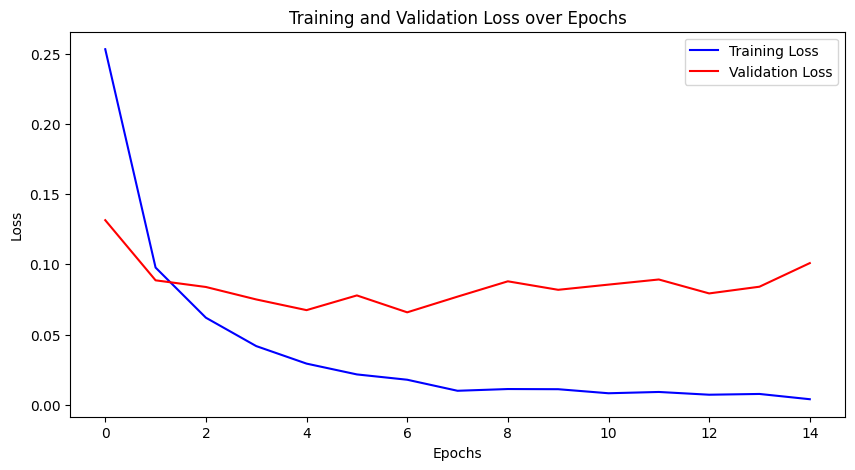

In [ ]:
# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='red')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

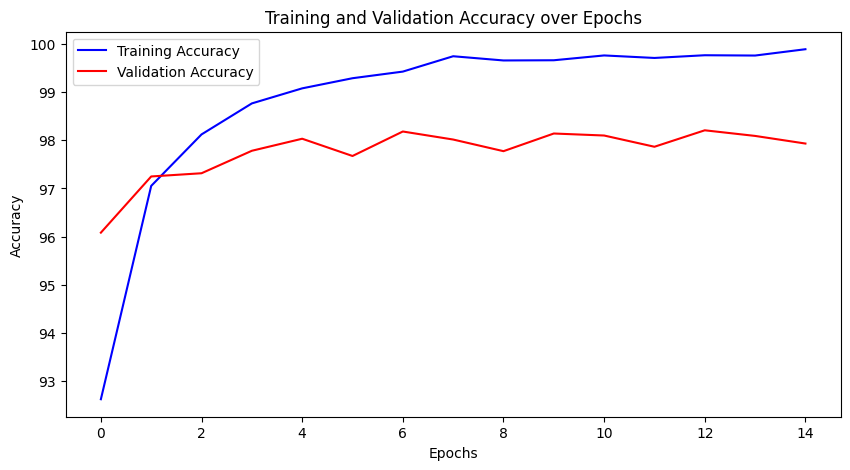

In [ ]:
# Plotting the training and validation accuracy

plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy', color='blue')
plt.plot(val_acc_list, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

From the graphs above, we are clearly overfitting. Overfitting is caused by many things such as lack of enough images, not using augmentation, etc...

## Testing

Now that we've finished training our model, we have to test it on our test dataset to see how it performs on unseen data. For this particular project, we have the ground truth labels for our test dataset, so we just use our eval function with our test dataset. Generally speaking, the function you write for evaluation will be extremely similar to the function you write for testing.

In [ ]:
test_loss, test_acc = eval(model, test_loader)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc}%')

Test loss: 0.1009
Test accuracy: 97.93333333333332%


## Conclusion

By going through this notebook we've seen the different stages of a deep learning project from start to finish. You can refer back to the slides and see how these different stages fit together and the role they play in the overall project.

## Exercises

The steps we covered in training a simple neural networks are quite straight forward, but it can feel daunting doing it from the first time. To give you more opportunity for understanding the steps of training neural networks, we are giving you exercises.

* We have used a network of 1 hidden layer. MNIST is a reasonably small dataset but let's try to increase the size of network to 3 hidden layers(with equal dimension or any dimension you prefer). Can you build and train this new network? What does this change on the overall performance?

* Take a few minutes going over [PyTorch image augmentation functions](https://pytorch.org/vision/main/transforms.html). Explore various augmentations that are relevant to our task and then use at least 2. Does this make significant improvements?